<a href="https://colab.research.google.com/github/KshitijMayank/Twitter_Scraping/blob/master/EDA_ML_Sentinment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os

# Word processing libraries
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# Widen the size of each cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

tweet1 = pd.read_csv('/content/drive/My Drive/Scrapped_Tweets/20200309_072709_Elections(anonymous).csv')
tweet2 = pd.read_csv('/content/drive/My Drive/Scrapped_Tweets/20200309_072709_Elections_(Set2).csv',quoting=3, error_bad_lines=False)
tweet3 = pd.read_csv('/content/drive/My Drive/Scrapped_Tweets/20200309_155552_Elections(set5).csv')
tweet4 = pd.read_csv('/content/drive/My Drive/Scrapped_Tweets/20200310_190209_Elections(set4).csv')
tweet5 = pd.read_csv('/content/drive/My Drive/Scrapped_Tweets/20200323_020823_Elections(set6).csv')
tweet6 = pd.read_csv('/content/drive/My Drive/Scrapped_Tweets/20200313_043503_Elections(set1).csv')


# Summary of the tweets
print(tweet1.shape,tweet1.info())
print('\n')
print(tweet2.shape,tweet2.info())
print('\n')
print(tweet3.shape,tweet3.info())
print('\n')
print(tweet4.shape,tweet4.info())

# Concatinating the dataset

data = pd.concat([tweet1,tweet2,tweet3,tweet4], axis = 0)
print('\n')
print('----------------_CONCATINATED INFORMATION--------------------')
print('Size of concatenated dataset is:', data.shape)

# Reset_index
data.reset_index(inplace = True, drop = True)
data.head()
print(data.info())

In [0]:
data.to_csv('Tweets_1.csv')

### TEXT CLEANING

In [0]:
data['username'].value_counts()
data[data['username']=='TeaRoadTiger']


# Let's drop duplicated rows:
print('Initial size of dataset before dropping duplicated rows:', data.shape)
data.drop_duplicates(keep = False, inplace = True)

print('Current size of dataset after dropping duplicated rows, if any, is:', data.shape)
print(data.head())

data.dropna(subset = ['text'], inplace = True)


# The unicode accounts for chinese characters and punctuations.
def strip_chinese_words(string):
    # list of english words
    en_list = re.findall(u'[^\u4E00-\u9FA5\u3000-\u303F]', str(string))
    
    # Remove word from the list, if not english
    for c in string:
        if c not in en_list:
            string = string.replace(c, '')
    return string
# Apply strip_chinese_words(...) on the column 'text'
data['text'] = data['text'].apply(lambda x: strip_chinese_words(x))
data.head()



# Define function to sieve out @users in a tweet:
def mentioned_users(string):
    usernames = re.findall('@[^\s]+', string)
    return usernames

# Create a new column and apply the function on the column 'text'
data['mentioned_users'] = data['text'].apply(lambda x: mentioned_users(x))
data.head()


# Define Emoji_patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

# Define the function to implement POS tagging:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


# Define the main function to clean text in various ways:
def clean_text(text):
    
    # Apply regex expressions first before converting string to list of tokens/words:
    # 1. remove @usernames
    text = re.sub('@[^\s]+', '', text)
    
    # 2. remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    
    # 3. remove hashtags entirely i.e. #hashtags
    text = re.sub(r'#([^\s]+)', '', text)
    
    # 4. remove emojis
    text = emoji_pattern.sub(r'', text)
    
    # 5. Convert text to lowercase
    text = text.lower()
    
    # 6. tokenize text and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # 7. remove numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # 8. remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # 9. remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # 10. pos tag text and lemmatize text
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # 11. remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    
    return(text)


# Apply function on the column 'text':
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))
data.head()

# Check out the shape again and reset_index
print(data.shape)
data.reset_index(inplace = True, drop = True)

# Check out data.tail() to validate index has been reset
data.tail()

Initial size of dataset before dropping duplicated rows: (68279, 11)
Current size of dataset after dropping duplicated rows, if any, is: (33855, 11)
         username  ...                                           hashtags
0  JustMe60155160  ...                                                 []
1   mommyfoursons  ...           [{'text': 'Trump', 'indices': [79, 85]}]
2       Srk1951mn  ...                                                 []
3       muneyball  ...  [{'text': 'Bernie', 'indices': [199, 206]}, {'...
4    JeffCordell6  ...                                                 []

[5 rows x 11 columns]
(33232, 13)


,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,mentioned_users,cleaned_text
33227,Know_God,"There is One God: Father, Son, & Holy Spirit. ...",in partibus infidelium,76,441,38255,2011-07-28 02:24:11,2020-03-10 18:14:46,68,This happened in Mexico 2 days ago on the so c...,"[{'text': 'InternationalWomensDay', 'indices':...",[],happen mexico day ago call \n\nthese pro-abort...
33228,meltsand,"Artist, Glassmaker, Cabinetmaker, Engineer, M...","Pacific Northwest, Olympic Rain Forest",6051,6095,49741,2012-03-23 16:40:01,2020-03-10 18:14:45,657,James #Biden &amp; @JoeBiden are implicated in...,"[{'text': 'Biden', 'indices': [22, 28]}, {'tex...",[@JoeBiden],james amp implicate massive hospital fraud pro...
33229,tribilintoby,NaN,NaN,2028,1471,288766,2009-07-17 21:39:25,2020-03-10 18:14:44,4,This never gets old! 😂😂\n.\n#GOP #Trump #Donal...,"[{'text': 'GOP', 'indices': [42, 46]}, {'text'...",[],never get old \n.\n
33230,SharkRadioNet,The Shark Radio Network is known for airing in...,NaN,2,526,23702,2020-02-10 20:51:47,2020-03-10 18:14:43,1,Interested in Starting a New Business? 8 Helpf...,"[{'text': 'NY', 'indices': [128, 131]}]",[],interested start new business helpful tip ihea...
33231,MarkStefanick,NaN,"Pennsylvania, USA",75,18,702,2019-04-27 12:08:16,2020-03-10 18:14:41,2881,#JoeBiden conveniently forgot he said this on ...,"[{'text': 'JoeBiden', 'indices': [20, 29]}, {'...",[],conveniently forget say camera self-avowed gun...


### CLEANING HSHTAGS NOW

In [0]:
# Import ast to convert a string representation of list to list
# The column 'hashtags' is affected
import ast

# Define a function to convert a string rep. of list to list
## Function should also handle NaN values after conversion
def strlist_to_list(text):
    
    # Remove NaN
    if pd.isnull(text) == True: # if true
        text = ''
    else:
      try:
        text = ast.literal_eval(text)
      except (ValueError,SyntaxError):
        text= ''
    return text

# Apply strlist_to_list(...) to the column 'hashtags'
# Note that doing so will return a list of dictionaries, where there will be one dictionary for each hashtag in a single tweet.
data['hashtags'] = data['hashtags'].apply(lambda x: strlist_to_list(x))
data.head()

# Since each 'hashtag' contain a list of dictionaries, we need to loop through the list to extract the actual hashtags in the tweets.
# Define a function to perform this extraction:
def extract_hashtags(hashtag_list):
    # argument:
    # hashtag_list - a list of dictionary(ies), each containing a hashtag
    
    # Create a list to store the hashtags
    hashtags = []
    
    # Loop through the list:
    for i in range(0, len(hashtag_list)):
        # extract the hashtag value using the key - 'text'
        # For our purposes, we can ignore the indices, which tell us the position of the hashtags in the string of tweet
        # lowercase the text as well
        hashtags.append(hashtag_list[i]['text'].lower())
        
    return hashtags
# Apply function on the column - data['hashtags']
data['hashtags'] = data['hashtags'].apply(lambda x: extract_hashtags(x))

# Check out the updated column 'hashtags'
print(data.head()['hashtags'])
data.head()

0                 []
1            [trump]
2                 []
3    [bernie, trump]
4                 []
Name: hashtags, dtype: object


,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,mentioned_users,cleaned_text
0,JustMe60155160,"Love my husband & children, freedom, the simpl...",NaN,4251,3632,3864,2019-10-02 23:49:46,2020-03-09 01:26:56,197,Do you think @realDonaldTrump has Gained or Lo...,[],[@realDonaldTrump],think gain lose supporter since election vote ...
1,mommyfoursons,loves America. concerns about Trump,"Phoenix, AZ.",558,441,31444,2016-10-10 00:04:45,2020-03-09 01:26:55,55,@DrJillStein Listen up JILL!\n\nEvery migrant ...,[trump],[@DrJillStein],listen jill!\n\nevery migrant soul torture con...
2,Srk1951mn,"Like Townes Van Zandt's classic, Waiting Aroun...","Wisconsin, USA",3332,3310,109303,2011-03-13 15:43:33,2020-03-09 01:26:55,24,"Hey, @realDonaldTrump , this is what real lead...",[],"[@realDonaldTrump, @YouTube]",hey real leadership america look like america ...
3,muneyball,Some people will eat anything. Speaking true o...,NaN,207,18,575,2020-02-06 03:12:47,2020-03-09 01:26:54,0,@carlquintanilla @CNBC @SquawkStreet Let's cut...,"[bernie, trump]","[@carlquintanilla, @CNBC, @SquawkStreet, @carl...",let's cut simplify long-term market see buy op...
4,JeffCordell6,Q follower since day 1! Blessed father livin...,"Tennessee, USA",352,375,8419,2017-12-03 04:03:28,2020-03-09 01:26:54,57,"Hey Deep state, FYI:\n\nNo matter how many fak...",[],[],hey deep state fyi:\n\nno matter many fake mag...


In [0]:
# Replace NaN (empty) values with n.a to indicate that the user did not state his location
# Define a function to handle this:
def remove_nan(text):
    if pd.isnull(text) == True: # entry is NaN
        text = 'n.a'
    else:
        # lowercase text for possible easy handling
        text = text.lower()
        
    return text
# Apply function on column - data['location']
data['location'] = data['location'].apply(lambda x: remove_nan(x))

# Check out the updated columns
print(data.head()['location'])


#  Let's take a quick look at the value_counts()
data['location'].value_counts()


# Apply function on column - data['location']
data['acctdesc'] = data['acctdesc'].apply(lambda x: remove_nan(x))

# Check out the updated columns
print(data.head()['acctdesc'])

# Importing VADER from NLTK
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create a sid object called SentimentIntensityAnalyzer()
sid = SentimentIntensityAnalyzer()

# Apply polarity_score method of SentimentIntensityAnalyzer()
data['sentiment'] = data['cleaned_text'].apply(lambda x: sid.polarity_scores(x))

# Keep only the compound scores under the column 'Sentiment'
data = pd.concat([data.drop(['sentiment'], axis = 1), data['sentiment'].apply(pd.Series)], axis = 1)



# New column: number of characters in 'review'
data['numchars'] = data['cleaned_text'].apply(lambda x: len(x))

# New column: number of words in 'review'
data['numwords'] = data['cleaned_text'].apply(lambda x: len(x.split(" ")))

# Check the new columns:
data.tail(2)

0               n.a
1     phoenix, az. 
2    wisconsin, usa
3               n.a
4    tennessee, usa
Name: location, dtype: object
0    love my husband & children, freedom, the simpl...
1                  loves america. concerns about trump
2    like townes van zandt's classic, waiting aroun...
3    some people will eat anything. speaking true o...
4    q follower since day 1!  blessed  father livin...
Name: acctdesc, dtype: object
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,mentioned_users,cleaned_text,neg,neu,pos,compound,numchars,numwords,neg,neu,pos,compound
33230,SharkRadioNet,the shark radio network is known for airing in...,n.a,2,526,23702,2020-02-10 20:51:47,2020-03-10 18:14:43,1,Interested in Starting a New Business? 8 Helpf...,[ny],[],interested start new business helpful tip ihea...,0.000,0.476,0.524,0.6705,54,7,0.000,0.476,0.524,0.6705
33231,MarkStefanick,n.a,"pennsylvania, usa",75,18,702,2019-04-27 12:08:16,2020-03-10 18:14:41,2881,#JoeBiden conveniently forgot he said this on ...,"[joebiden, betoorourke]",[],conveniently forget say camera self-avowed gun...,0.211,0.514,0.275,0.2732,169,24,0.211,0.514,0.275,0.2732


In [0]:
# Import the Gensim package
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data["cleaned_text"].apply(lambda x: x.split(" ")))]

# Train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size = 10, window = 2, min_count = 1, workers = 4)

# Transform each document into a vector data
doc2vec_df = data["cleaned_text"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
data = pd.concat([data, doc2vec_df], axis = 1)

# Check out the newly added columns:
data.tail(2)

In [0]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Call the function tfidfvectorizer
# min_df is the document frequency threshold for ignoring terms with a lower threshold.
# stop_words is the words to be removed from the corpus. We will check for stopwords again even though we had already performed it once previously.
# We will only consider a maximum of 100 features since in our previous runs.
tfidf = TfidfVectorizer(
    max_features = 100,
    min_df = 10,
    stop_words = 'english'
)

# Fit_transform our 'revi`ew' (the corpus) using the tfidf object from above
tfidf_result = tfidf.fit_transform(data['cleaned_text']).toarray()

# Extract the frequencies and store them in a temporary dataframe
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())

# Rename the column names and index
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = data.index

# Concatenate the two dataframes - 'dataset' and 'tfidf_df'
# Note: Axis = 1 -> add the 'tfidf_df' dataframe along the columns  or add these columns as columns in 'dataset'.
data = pd.concat([data, tfidf_df], axis = 1) 

# Check out the new 'dataset' dataframe
data.tail(2)


from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['cleaned_text'])


No of positive and negative sentiment

In [0]:

# Focus on 'compound' scores
# Create a new column called 'sentiment_class'
sentimentclass_list = []

for i in range(0, len(data)):
    
    # current 'compound' score:
    curr_compound = data.iloc[i,:]['compound']
    
    if (curr_compound <= 1.0 and curr_compound >= 0.55):
        sentimentclass_list.append(5)
    elif (curr_compound < 0.55 and curr_compound >= 0.10):
        sentimentclass_list.append(4)
    elif (curr_compound < 0.10 and curr_compound > -0.10):
        sentimentclass_list.append(3)
    elif (curr_compound <= -0.10 and curr_compound > -0.55):
        sentimentclass_list.append(2)
    elif (curr_compound <= -0.55 and curr_compound >= -1.00):
        sentimentclass_list.append(1)

# Add the new column 'sentiment_class' to the dataframe
data['sentiment_class'] = sentimentclass_list

# Check out the new column
data.tail()['sentiment_class']

data.iloc[0:5, :][['compound', 'sentiment_class']]


import seaborn as sns

# Distribution of sentiment_class
plt.figure(figsize = (10,5))
sns.set_palette('PuBuGn_d')
sns.countplot(data['sentiment_class'])
plt.title('Countplot of sentiment_class')
plt.xlabel('sentiment_class')
plt.ylabel('No. of classes')
plt.show()


# Display full text:
pd.set_option('display.max_colwidth', -1)

In [0]:

# Look at some examples of negative, neutral and positive tweets

# Filter 10 negative original tweets:
print("10 random negative original tweets and their sentiment classes:")
data[(data['sentiment_class'] == 1) | (data['sentiment_class'] == 2)].sample(n=10)[['text', 'sentiment_class']]

In [0]:

# Filter 10 neutral original tweets:
print("10 random neutral original tweets and their sentiment classes:")
data[(data['sentiment_class'] == 3)].sample(n=10)[['text', 'sentiment_class']]


In [0]:
# Filter 20 positive original tweets:
print("20 random positive original tweets and their sentiment classes:")
data[(data['sentiment_class'] == 4) | (data['sentiment_class'] == 5)].sample(n=20)[['text', 'sentiment_class']]

**Now getting the most popular Hashtags**

In [0]:
#  the column data['hashtags'] returns a list of string(s) for each tweet.
# Build a list of all hashtags in the dataset

hashtag_list = []

for i in range(0, len(data)):
    # Obtain the current list of hashtags
    curr_hashtag = data.iloc[i, :]['hashtags']
    
    # Extract and append the hashtags to 'hashtag_list':
    for j in range(0, len(curr_hashtag)):
        hashtag_list.append(curr_hashtag[j])
    
# Print out the list
print(hashtag_list)

print('No. of hashtags used in {} tweets is {}'.format(len(data), len(hashtag_list)))

# Now we have the list of hashtags, we can convert this into a simple DataFrame, which will be used for visualization.
df_hashtag = pd.DataFrame(
    {'hashtags': hashtag_list}
)

print(df_hashtag.head())
print('Shape of df_hashtag is:', df_hashtag.shape)

['trump', 'bernie', 'trump', 'h1bs', 'maga', 'h1b', 'opt', 'h4ead', 's386', 'yanggang', 'ubi', 'biden', 'trump', 'bernie', 'peggyforillinois', 'maga', 'kag', 'ifb', 'god', 'farmer', 'freedom', '2ndamendment', 'prolife', 'potus', 'patriots', 'maga', 'kag', 'buildthewall', 'israel', 'donaldtrump', 'covid19', 'maximumtrump', 'democrats', 'climatechangeisreal', 'russianinterference', 'elections', 'impeachment', 'impeachedforever', 'trump', 'pence', 'trump', 'draintheswamp', 'il14', 'twill', 'coronavirus', 'resist', 'socialmedia', 'politics', 'trump', 'coronavirus', 'trumpeconomy', 'democrats', 'usa', 'canada', 'dst', 'enddst', 'daylightsavingstime', 'votebluenomatterwho', 'trump', 'votebluenomatterwho', 'joementum', 'charliedaniels', 'schumer', 'trumpslump', 'trumpvirus', 'dumptrump2020', 'liarinchief', 'cdc', 'coronavirusoutbreak', 'stockmarketcrash2020', 'corrupttrump', 'votethemallout2020', 'votebluenomatterwho', 'biden2020', 'grifters', 'pencedemic', 'voteblue', 'il14', 'yanggang', 'qa

***All time top N hashtags***

           hashtags  counts
2235  joebiden       6207  
2520  maga           5261  
377   betoorourke    4466  
4258  trump          3539  
870   coronavirus    1751  
2284  kag2020        1267  
352   berniesanders  1239  
2283  kag            1109  
4260  trump2020      882   
384   biden          754   
1110  democrat       742   
4694  walkaway       722   
3536  resist         624   
317   bernie         531   
1103  demexit        496   


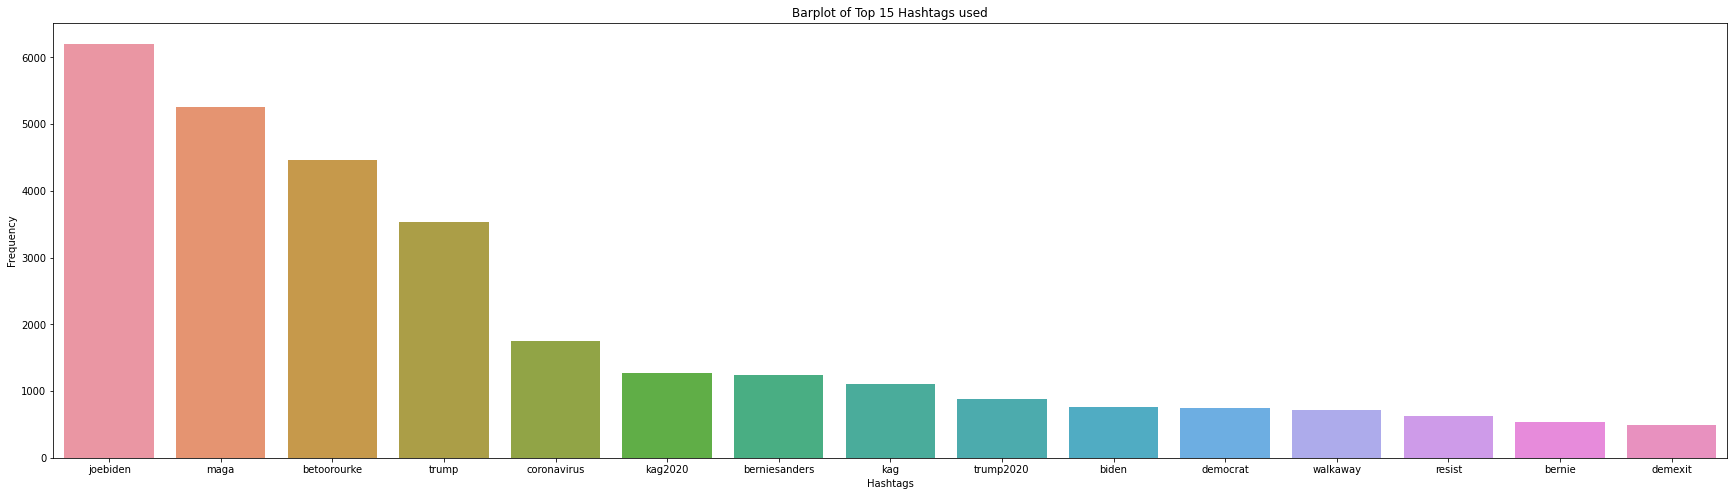

In [0]:
N = 15
top_hashtags = df_hashtag.groupby(['hashtags']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False).head(N)
print(top_hashtags)

# seaborn countplot on the top 30 hashtags
plt.figure(figsize=(30,8))
sns.set_palette('PuBuGn_d')
sns.barplot(x = 'hashtags', y = 'counts', data = top_hashtags)
plt.title('Barplot of Top ' + str(N) + ' Hashtags used')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.show()

### **Trend of Hashtags with time**

In [0]:
from datetime import datetime

ind_to_drop = []
date = []

# First find out which 'tweetcreatedts' is not a string or in other weird formats
for i in range(0, len(data)):
    ith_date_str = data.iloc[i,:]['tweetcreatedts']
    ith_match = re.search(r'\d{4}-\d{2}-\d{2}', ith_date_str)
    if ith_match == None:
        ind_to_drop.append(i)
    else:
        continue
# Drop these rows using ind_to_drop
data.drop(ind_to_drop, inplace = True)
# Check new shape
data.shape

#  Create a new list of datetime date objects from the tweets:
for i in range(0, len(data)):
    ith_date_str = data.iloc[i, :]['tweetcreatedts']
    ith_match = re.search(r'\d{4}-\d{2}-\d{2}', ith_date_str)
    ith_date = datetime.strptime(ith_match.group(), '%Y-%m-%d').date()
    
    date.append(ith_date)
    
# Size of list 'date'
print('Len of date list: ', len(date))
#  Append 'date' to dataframe 'data' as 'dt_date' aka 'datetime_date'
data['dt_date'] = date

data['dt_date'].value_counts()

Len of date list:  30222


2020-03-09    16776
2020-03-10    13446
Name: dt_date, dtype: int64

Unique dates available in this dataset are: [datetime.date(2020, 3, 9) datetime.date(2020, 3, 10)]
The newly created timeseries_hashtag of size (20, 4) is: 


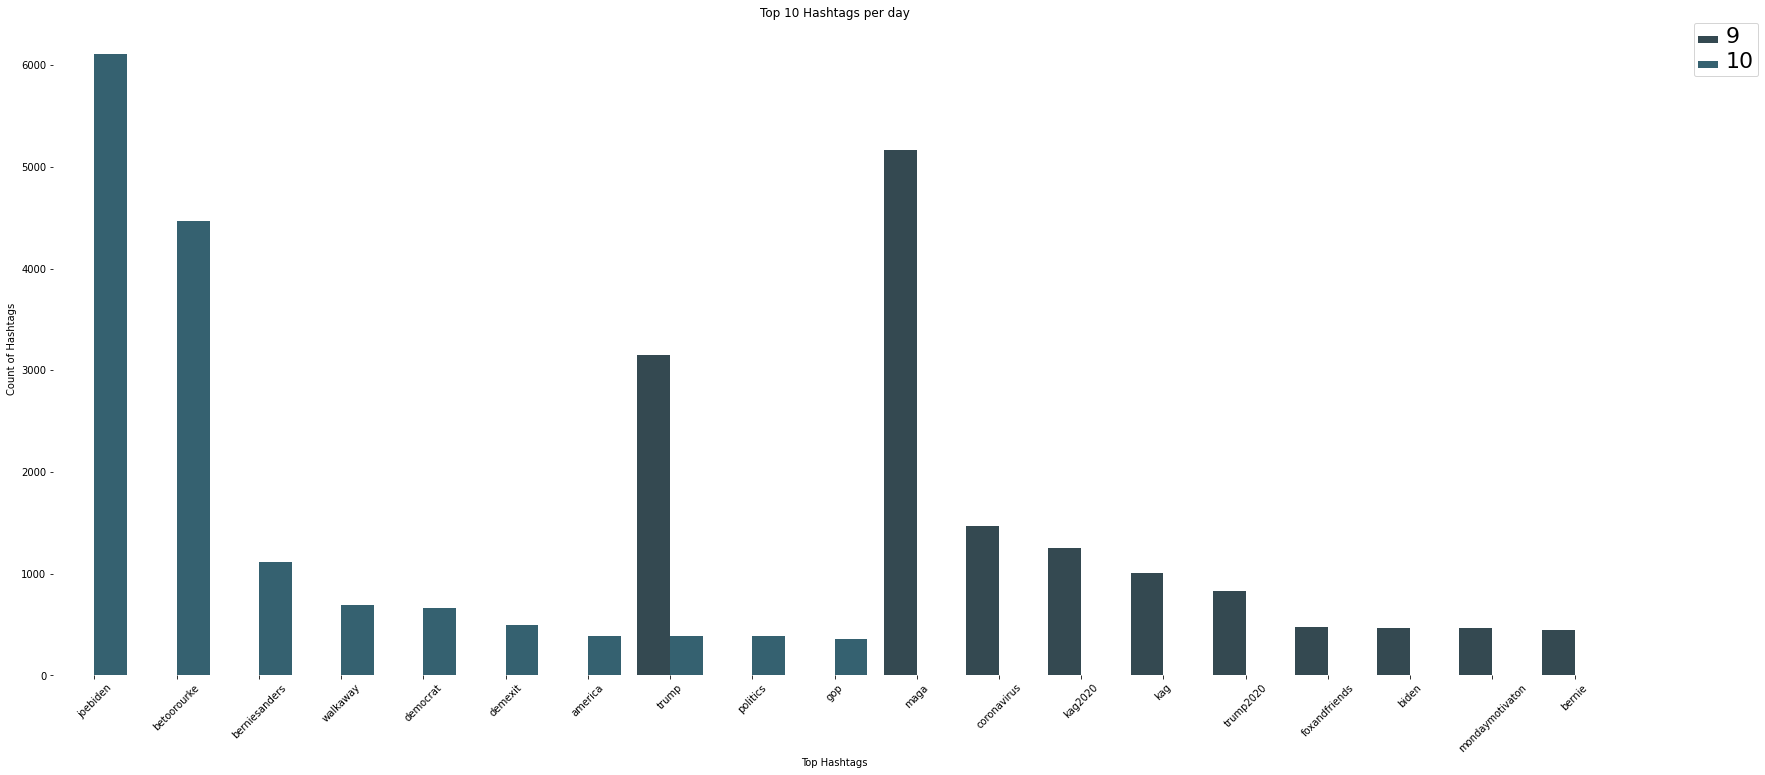

In [0]:
# Create a new dataframe first
timeseries_hashtags = pd.DataFrame(columns = ['hashtags', 'count', 'date', 'dayofnov'])

# Obtain a set of unique dates in 'date' list:
unique_date = np.unique(date)



print('Unique dates available in this dataset are:', unique_date)
# Define a function to create a visualization of top N hashtags for T number of days
def visualize_top_hashtags(main_df, timeseries_df, N, T, unique_dates):
    # main_df - main dataframe 'data'
    # timeseries_df - a new and empty dataframe to store the top hashtags 
    # N - number of top hashtags to consider
    # T - number of days to consider
    # unique_dates - list of unique dates available in the table
    
    # Returns:
    # timeseries_df
    
    # Start counter to keep track of number of days already considered
    counter = 1

    # Starting from the latest date in the list
    for ith_date in reversed(unique_dates):
        # Check if counter exceeds the number of days required, T:
        if counter <= T:
            
            # Filter tweets created on this date:
            ith_date_df = main_df[main_df['dt_date'] == ith_date]

            # From this particular df, build a list of all possible hashtags:
            ith_hashtag_list = []

            for i in range(0, len(ith_date_df)):
                # Obtain the current list of hashtags:
                curr_hashtag = ith_date_df.iloc[i,:]['hashtags']

                # Extract and append the hashtags to 'hashtag_list':
                for j in range(0, len(curr_hashtag)):
                    ith_hashtag_list.append(curr_hashtag[j])

            # Convert the list into a simple DataFrame
            ith_df_hashtag = pd.DataFrame({
                    'hashtags': ith_hashtag_list
            })

            # Obtain top N hashtags:
            ith_top_hashtags = ith_df_hashtag.groupby(['hashtags']).size().reset_index(name = 'count').sort_values(by = 'count', ascending = False).head(N)

            # Add date as a column
            ith_top_hashtags['date'] = ith_date
            ith_top_hashtags['dayofnov'] = ith_date.day

            # Finally, concat this dataframe to timeseries_hashtags
            timeseries_df = pd.concat([timeseries_df, ith_top_hashtags], axis = 0)

            # Increase counter by 1
            counter += 1
        
        else: # break the for loop
            break
    
    print('The newly created timeseries_hashtag of size {} is: '.format(timeseries_df.shape))
    timeseries_df.reset_index(inplace = True, drop = True)
    
    # Visualization
    plt.figure(figsize=(28,12))
    ax = sns.barplot(x = 'hashtags', 
                   y = 'count',
                   data = timeseries_df,
                   hue = 'dayofnov')

    # plt.xticks(np.arange(3, 6, step=1))
    # Moving legend box outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # for legend text
    plt.setp(ax.get_legend().get_texts(), fontsize='22')
    # for legend title
    plt.setp(ax.get_legend().get_title(), fontsize='32') 
    plt.xlabel('Top Hashtags')
    plt.ylabel('Count of Hashtags')
    plt.title('Top ' + str(N) + ' Hashtags per day')
    sns.despine(left=True, bottom=True)
    plt.xticks(rotation = 45)
    plt.show()
    
    return timeseries_df


# Call function

timeseries_hashtags = visualize_top_hashtags(main_df = data,
                       timeseries_df = timeseries_hashtags,
                       N = 10,
                       T = 7,
                       unique_dates = unique_date)

## **TOP USED @USERNAMES** Marked Against the number of usage in the tweets


In [0]:
def find_users(df):
    # df: dataframe to look at
    # returns a list of usernames
    
    # Create empty list
    list_users = []
    
    for i in range(0, len(df)):
        users_ith_text = re.findall('@[^\s]+', df.iloc[i,:]['text'])
        # returns a list
        # append to list_users by going through a for-loop:
        for j in range(0, len(users_ith_text)):
            list_users.append(users_ith_text[j])
    
    return list_users

# Apply on dataframe data['text']
list_users = find_users(data)

mentioned_users_df = pd.DataFrame({
    'mentioned_users': list_users
})

mentioned_users_df.head()

mentionedusers = mentioned_users_df.groupby('mentioned_users').size().reset_index(name = 'totalcount').sort_values(by = 'totalcount', ascending = False)
mentionedusers.head()

,mentioned_users,totalcount
4862,@realDonaldTrump,3733
1522,@JoeBiden,725
2290,@POTUS,472
368,@BernieSanders,367
337,@BarackObama,229


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8297 missing from current font.
  font.set_text(s, 0, flags=flags)


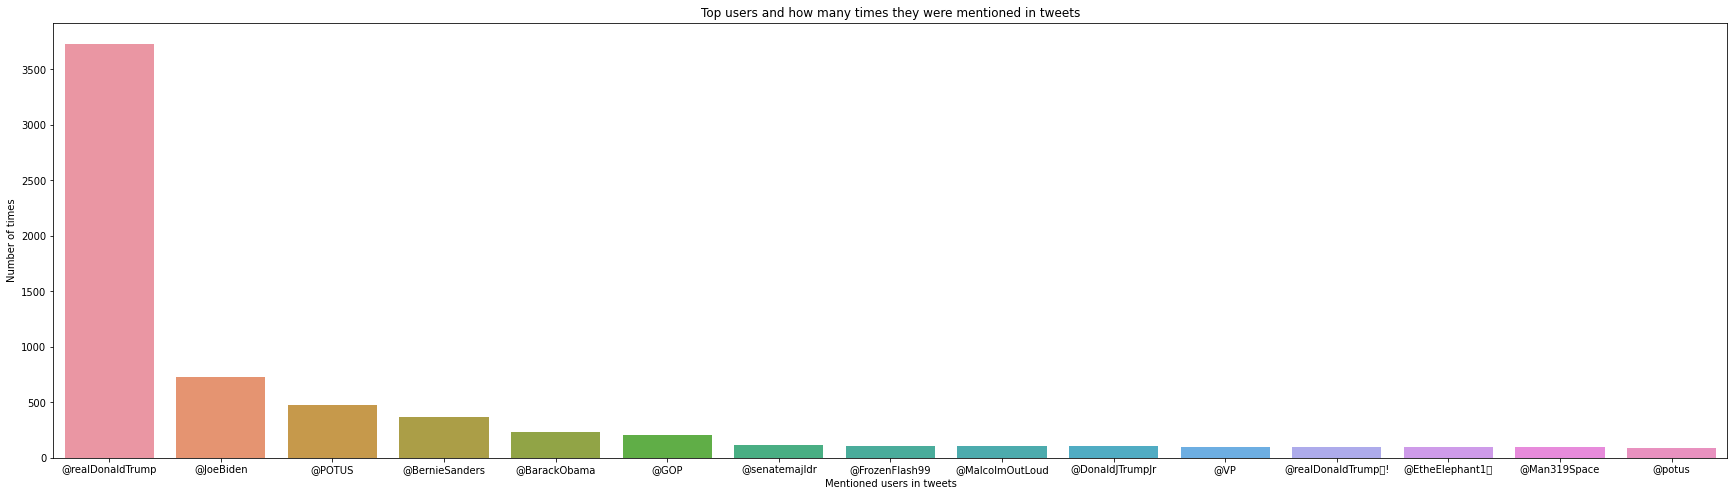

In [0]:
plt.figure(figsize=(30,8))
sns.set_palette('PuBuGn_d')
sns.barplot(x = 'mentioned_users', y = 'totalcount', data = mentionedusers.head(15))
plt.xlabel('Mentioned users in tweets')
plt.ylabel('Number of times')
plt.title('Top users and how many times they were mentioned in tweets')
plt.show()

## **USER GEOGRAPHIC DEMOGRAPHICS**

No. of distinct locations listed by twitter users is: 5496
                         locations  count
0     n.a                           9650 
1     united states                 1401 
2     usa                           640  
3     texas, usa                    373  
4     california, usa               342  
...               ...               ...  
5491  stevens point, wi             1    
5492  banned.video                  1    
5493  thailand, the land of thais.  1    
5494   north carolina💙🐏             1    
5495  sherrill ford nc              1    

[5496 rows x 2 columns]
                         locations  count
1     united states                 1401 
2     usa                           640  
3     texas, usa                    373  
4     california, usa               342  
5     florida, usa                  328  
...            ...                  ...  
5491  stevens point, wi             1    
5492  banned.video                  1    
5493  thailand, the land of thais.

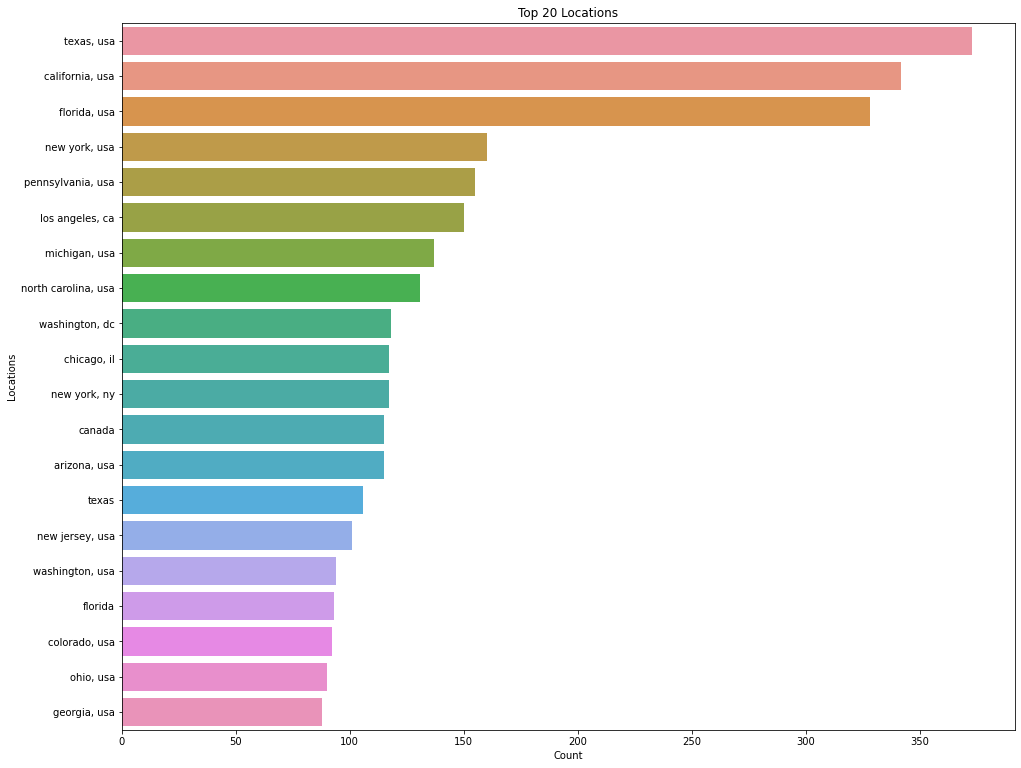

In [0]:

location = data['location']
print('No. of distinct locations listed by twitter users is:', len(location.value_counts()))
unique_locations = location.value_counts()
# print(pd.DataFrame(location))

# Remove na values Remove n.a.
unique_locations = pd.DataFrame({'locations': unique_locations.index,
                                'count': unique_locations.values})

print(unique_locations)

# Dropping the na's
unique_locations.drop(0, inplace = True)

print(unique_locations)

# See top few locations
unique_locations.sort_values(by = 'count', ascending = False).head(10)


# Dropping irrelevant values like usa, earth , etc...
# print(unique_locations['locations'])
ind_1 = unique_locations[unique_locations['locations'] == 'united states'].index.values[0]
ind_2 = unique_locations[unique_locations['locations'] == 'usa'].index.values[0]
ind_3 = unique_locations[unique_locations['locations'] == 'earth'].index.values[0]
unique_loc_temp =unique_locations.drop([ind_1,ind_2,ind_3])
# print(unique_locations['locations']=='usa')
# print('HERE:-------',unique_locations[unique_locations['locations'] == 'united states'].index.values[0])


# Focus on top 20 locations first
# Convert any possible str to int/numeric first

count = pd.to_numeric(unique_loc_temp['count'])
unique_loc_temp['count'] = count
unique_loc_temp = unique_loc_temp.head(20)

# Plot a bar plot
plt.figure(figsize=(16,13))
sns.set_palette('PuBuGn_d')
sns.barplot(x = 'count', y = 'locations', orient = 'h',data = unique_loc_temp)
plt.xlabel('Count')
plt.ylabel('Locations')
plt.title('Top 20 Locations')
plt.show()

